<a href="https://colab.research.google.com/github/Hojin-Sa/Deep_Learning/blob/main/CIFAR10_TEST_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10을 CNN으로 학습하기. 여러 학습방법으로 비교!

In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.006
num_epoch=100

## 1. CIFAR10 train, test dataset 가져오기 (163MB)

In [58]:
#cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# (2) Data augmentation
#cifar_train=dset.CIFAR10("CIFAR10/", train=True,
#                         transform=transforms.Compose([
#                             transforms.Resize(36),
#                             transforms.CenterCrop(32),
#                             transforms.RandomHorizontalFlip(),
#                             transforms.Lambda(lambda x: x.rotate(90)),
#                             transforms.ToTensor()
#                         ]))


#cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#(4) Data Normalization
cifar_train = dset.CIFAR10("CIFAR10/", train=True,
                           transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),                         
                           ])
                           , target_transform=None, download=True)
cifar_test = dset.CIFAR10("CIFAR10/", train=False,
                           transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),                         
                           ])
                           , target_transform=None, download=False)



Files already downloaded and verified


## 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label:  7


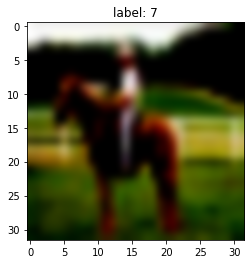

In [59]:
print ("cifar_train 길이:", len(cifar_train))
print ("cifar_test 길이:", len(cifar_test))

#데이터 하나 형태
image, label = cifar_train.__getitem__(22341) # 22341번째 데이터
print("image data 형태:", image.size())
print("label: ", label)

#그리기
img = image.numpy()  # image타입을 numpy로 변환 (3,32,32)

# (3,32,32) -> (32,32,3)
r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label )
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [60]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs,labels] in enumerate(dloader): #batch_size만큼 
    img = Variable(imgs,requires_grad = True).cuda()
    label = Variable(labels).cuda()

    output = imodel.forward(img) # forward prop.
    _, output_index = torch.max(output,1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}".format(100*correct/total))

In [61]:
# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4. 모델 선언 ===
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),  # (2) drop out
        nn.BatchNorm2d(16),  # (6) Batch normalization
        nn.Conv2d(16,32,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm1d(100),
        nn.Linear(100,10)
    )
     #(3) weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)  #REUL 일때
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight.data)  
        m.bias.data.fill_(0)
  
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out
model=CNN().cuda()

In [ ]:
# === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) # (6) Adam optimizer
model.train()
#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) # (7) learning rate dacay

# === 6. 학습 ===
for i in range(num_epoch):
  
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j,loss)
 

0 tensor(3.0400, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.8053, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.4013, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(2.0014, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(1.8190, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.6196, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.4377, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(1.3776, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.1020, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.4778, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.4882, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(0.9258, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.2273, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.4088, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.3446, device='cuda:0', grad_fn=<NllLos

## (0) Naive Test

In [ ]:
#model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 23.34000015258789


## (1) drop out

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 17.829999923706055


## (2) Data augmentation

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 12.520000457763672


## (3) Weight initialization

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 41.5


## (4) Data Normalization

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 31.799999237060547


## (5) Batch normalization

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 59.95000076293945


## (6) Adam optimizer

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 60.08000183105469


## (7) learning rate dacay

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 65.6199951171875


## `Weight initialization + learning rate dacay`

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 68.58999633789062


## drop out + Weight initialization + learning rate dacay  (epoch=40) 

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 69.65999603271484


## drop out + Weight initialization + Batch normalization +learning rate dacay

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 65.94999694824219


## drop out + Weight initialization + Batch normalization + ELU 

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 66.26000213623047


## drop out + Weight initialization + learning rate dacay + batch_size=32, epoch=60

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 69.05048370361328


## drop out + Weight initialization + learning rate dacay + batch_size=64, epoch= 40

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 68.09896087646484


## drop out + Weight initialization + learning rate dacay + batch_size=32, epoch= 100

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 66.78685760498047


## drop out + Weight initialization + Data Normalization + Adam + batch_size=16, epoch=60

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 67.72999572753906


## drop out + Weight initialization + learning rate dacay (epoch 400)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 68.6199951171875


## drop out + Weight initialization + learning rate dacay (epoch 150)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 69.25


## drop out + Data Normalization + learning rate dacay (epoch 150)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 67.43999481201172


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) 

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 70.54000091552734


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) Learning rate:0.005

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.86000061035156


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) (Learning rate:0.005) (batch_size = 32)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.37580108642578


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) (Learning rate:0.006) 

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 73.18999481201172


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 100) (Learning rate:0.006) 

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.20999908447266


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 250) (Learning rate:0.006)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.83000183105469


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) (Learning rate:0.007)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 73.04000091552734


## drop out + Data Normalization + Batch normalization + Weight initialization +learning rate dacay (epoch 150) (Learning rate:0.006)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 70.15999603271484


## drop out + Data Augmentation + Batch normalization + learning rate dacay (epoch 60) (Learning rate:0.006)

In [10]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 28.399999618530273


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 60) (Learning rate:0.006)

In [17]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.22999572753906


## drop out + Data Normalization + Batch normalization + learning rate dacay (epoch 150) (Learning rate:0.006)  (drop out에서 0,2 -> 0.2로 수정)

In [19]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.0


## drop out + Data Normalization + Batch normalization +(epoch 150) (Learning rate:0.006)


In [26]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.40999603271484


## drop out + Weight initialization + Data Normalization + Batch normalization +(epoch 150) (Learning rate:0.006)

In [33]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.1199951171875


## drop out + Weight initialization + Batch normalization +(epoch 150) (Learning rate:0.006)

In [40]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 73.36000061035156


## drop out + Data Normalization + Batch normalization +ELU +(epoch 150) (Learning rate:0.006)

In [49]:
model.eval()
netname = './nets/my_net25.pkl'
torch.save(model, netname, )

model = torch.load(netname)
ComputeAccr(test_loader,model)

Accuracy of Test Data: 76.04999542236328


## drop out + Data Normalization + Batch normalization +ELU +(epoch 150) (Learning rate:0.006)   (model.train(), model.eval()을 학습 반복문안에)

In [56]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 76.29999542236328


## drop out + Data Normalization + Batch normalization +ELU +(epoch 100) (Learning rate:0.006)

In [ ]:
model.eval()
ComputeAccr(test_loader,model)